# Introduction

API doc:https://binance-docs.github.io/apidocs/spot/en/

The Following API can return all historical trading related data of tokens activated in Binance enchanges. 

In [36]:
# Packages
import time
import json
import talib as ta
import requests
import pandas as pd
import numpy as np
import datetime
from urllib.parse import urljoin, urlencode
from dateutil import parser


# Obtian the exchange info

In [37]:
# Obtain the exchange information firstly
def exchangeInfo():
    BASE_URL = 'https://api.binance.com'
    PATH = '/api/v3/exchangeInfo'
    
    url = urljoin(BASE_URL, PATH)
    
    response = requests.get(url)

    data = response.json()
    data = pd.DataFrame(data['symbols'])
    return data

In [38]:
tokenInfo = exchangeInfo()

tokenInfo.head()

,symbol,status,baseAsset,baseAssetPrecision,quoteAsset,quotePrecision,quoteAssetPrecision,baseCommissionPrecision,quoteCommissionPrecision,orderTypes,icebergAllowed,ocoAllowed,quoteOrderQtyMarketAllowed,isSpotTradingAllowed,isMarginTradingAllowed,filters,permissions
0,ETHBTC,TRADING,ETH,8,BTC,8,8,8,8,"[LIMIT, LIMIT_MAKER, MARKET, STOP_LOSS_LIMIT, ...",True,True,True,True,True,"[{'filterType': 'PRICE_FILTER', 'minPrice': '0...","[SPOT, MARGIN]"
1,LTCBTC,TRADING,LTC,8,BTC,8,8,8,8,"[LIMIT, LIMIT_MAKER, MARKET, STOP_LOSS_LIMIT, ...",True,True,True,True,True,"[{'filterType': 'PRICE_FILTER', 'minPrice': '0...","[SPOT, MARGIN]"
2,BNBBTC,TRADING,BNB,8,BTC,8,8,8,8,"[LIMIT, LIMIT_MAKER, MARKET, STOP_LOSS_LIMIT, ...",True,True,True,True,True,"[{'filterType': 'PRICE_FILTER', 'minPrice': '0...","[SPOT, MARGIN]"
3,NEOBTC,TRADING,NEO,8,BTC,8,8,8,8,"[LIMIT, LIMIT_MAKER, MARKET, STOP_LOSS_LIMIT, ...",True,True,True,True,True,"[{'filterType': 'PRICE_FILTER', 'minPrice': '0...","[SPOT, MARGIN]"
4,QTUMETH,TRADING,QTUM,8,ETH,8,8,8,8,"[LIMIT, LIMIT_MAKER, MARKET, STOP_LOSS_LIMIT, ...",True,True,True,True,False,"[{'filterType': 'PRICE_FILTER', 'minPrice': '0...",[SPOT]


In [39]:
# tokenInfo.to_csv("Exchange_info.csv")

# example
tokenInfo['symbol'][0]

'ETHBTC'

# obtain the historicl data of tokens

Binance exchange provides from monthly frequency data to minute frequency data.

In [40]:
# timedelta_fre = ['W','D','hours','m','s','ms']
itv = ["1m","3m","5m","15m","30m","1h","2h","4h","6h","8h","12h","1d","3d","1w","1M"]

# historical of token price should be indexed by its symbol.
smb = tokenInfo['symbol']

In [41]:
def start_end_time(startTime,interval,length = 1000):
#     Due to the limit of the api, we need a function to help cut a long time into small period.
#     The function input the start time and interval and return the start time and endtime. 
#     
#     read the time
    startTime = datetime.datetime.strptime(startTime, "%Y-%m-%d %H:%M:%S")
    
#     unit 
    unit = interval
#     transfer the interval frequence
    if unit in ["1m","3m","5m","15m","30m"]:
        unit = 'm'
    elif unit in ["1h","2h","4h","6h","8h","12h"]:
        unit = 'hours'
    elif unit in ["1d","3d"]:
        unit = 'D'
    else:
        unit = 'W'
        
    endTime = pd.to_datetime(startTime)+pd.to_timedelta(length, unit = unit)

    startTime = datetime.datetime.timestamp(startTime)*1000
    endTime = datetime.datetime.timestamp(endTime)*1000
    
    return str(int(startTime)),str(int(endTime))

In [42]:
def klines(symbol,startTime,endTime,interval):
#    This function is aimed to gather the historical price data.    
    BASE_URL = 'https://api.binance.com'
    PATH = '/api/v3/klines'
    
    params = {
        'symbol': symbol,
        'interval': interval,
        'startTime':startTime,
        'endTime':endTime,
        'limit':1000 # 500/1000 is the limit for each request
    }

    url = urljoin(BASE_URL, PATH)

    response = requests.get(url,params=params)

    data = response.json()
    data = pd.DataFrame(data)
#     change the cols
    col = ['Open time','Open','High','Low','Close','Volume','Close time','Quote asset volume','Number of trades',
       'Taker buy base asset volume','Taker buy quote asset volume','Ignore']
    
    if not data.empty:
        data.columns = col
#       transfer the timestamp into time
        data['Open time'] = pd.to_datetime(data['Open time'],unit='ms',utc=True)
        data['Close time'] = pd.to_datetime(data['Close time'],unit='ms',utc=True)
        return data
    else:
        print('No data')

# Sample of data

After build the function of API and exchange information, we can now obtain every token with every period data.

For example, we here use famous 1m BTC as our data sample.

计算features

In [43]:
def max_min_scaler(data:list):
    
    data = data[~np.isnan(data)]
    if not data.empty:
        data =  (data-min(data))/(max(data)-min(data))
        return data.values[-1]
    else:
        return 'NaN'

In [44]:
def multiple_ta(data):
    high = data['High']
    low = data['Low']
    close = data['Close']
    volume = data['Volume']
    
    # ta Overlap Studies Functions && max_min_scaler
    ind_upperband, ind_middleband, ind_lowerband = ta.BBANDS(close, timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)
    ind_upperband = max_min_scaler(ind_upperband)
    ind_middleband = max_min_scaler(ind_middleband)
    ind_lowerband = max_min_scaler(ind_lowerband)
    
    ind_dema = ta.DEMA(close, timeperiod=30)
    ind_dema = max_min_scaler(ind_dema)
    
    ind_ema = ta.EMA(close, timeperiod=30)
    ind_ema = max_min_scaler(ind_ema)
    
    ind_ht_trendline = ta.HT_TRENDLINE(close)
    ind_ht_trendline = max_min_scaler(ind_ht_trendline)
    
    # Momentum Indicator Functions
    ind_macd, ind_macdsignal, ind_macdhist = ta.MACD(close, fastperiod=12, slowperiod=26, signalperiod=9)
    ind_macd = max_min_scaler(ind_macd)
    ind_macdsignal = max_min_scaler(ind_macdsignal)
    ind_macdhist =  max_min_scaler(ind_macdhist)
    
    ind_mfi = ta.MFI(high, low, close, volume, timeperiod=14)
    ind_mfi = max_min_scaler(ind_mfi)
    
    ind_willr = ta.WILLR(high, low, close, timeperiod=14)
    ind_willr = max_min_scaler(ind_willr)
    
    # new-20211107
    ind_ADX = ta.ADX(high, low, close, timeperiod=14)
    ind_ADX = max_min_scaler(ind_ADX)
    
    ind_ADXR = ta.ADXR(high, low, close, timeperiod=14)
    ind_ADXR = max_min_scaler(ind_ADXR)
    
    ind_APO = ta.APO(close, fastperiod=12, slowperiod=26, matype=0)
    ind_APO = max_min_scaler(ind_APO)
    
    ind_aroondown, ind_aroonup = ta.AROON(high, low, timeperiod=14)
    ind_aroondown = max_min_scaler(ind_aroondown)
    ind_aroonup = max_min_scaler(ind_aroonup)
    
    ind_AROONOSC = ta.AROONOSC(high, low, timeperiod=14)
    ind_AROONOSC = max_min_scaler(ind_AROONOSC)
    
    
    
    # Volume Indicator Functions
    ind_ad = ta.AD(high, low, close, volume)
    ind_ad = max_min_scaler(ind_ad)
    
    ind_adosc = ta.ADOSC(high, low, close, volume, fastperiod=3, slowperiod=10)
    ind_adosc = max_min_scaler(ind_adosc)
    
    ind_obv = ta.OBV(close, volume)
    ind_obv = max_min_scaler(ind_obv)
    
    # Volatility Indicator Functions
    ind_atr = ta.ATR(high, low, close, timeperiod=14)
    ind_atr = max_min_scaler(ind_atr)
    
    ind_natr = ta.NATR(high, low, close, timeperiod=14)
    ind_natr = max_min_scaler(ind_natr)
    
    ind_trange = ta.TRANGE(high, low, close)
    ind_trange =  max_min_scaler(ind_trange)
    
    
        
    
    ind_list = [ind_upperband,ind_middleband,ind_lowerband,ind_dema,ind_ema,ind_ht_trendline, # Overlap Studies Functions
                ind_macd,ind_macdsignal,ind_macdhist,ind_mfi,ind_willr,ind_ADX,ind_ADXR,ind_APO,ind_aroondown,ind_aroonup,ind_AROONOSC,# Momentum Indicator Functions
                ind_ad,ind_adosc,ind_obv, # Volume Indicator Functions
                ind_atr,ind_natr,ind_trange] # Volatility Indicator Functions
    
    name_list = ['BBANDS_upperband','BBANDS_middleband','BBANDS_lowerband','DEMA','EMA','HT_TRENDLINE', 
                 'macd','macdsignal','macdhist','mfi','willr', 'ADX','ADXR','APO','aroondown','aroonup','AROONOSC',# Momentum Indicator Functions
                'ad','adosc','obv', # Volume Indicator Functions
                'atr','natr','trange']
    

    return ind_list,name_list


In [45]:
def convert_dataframe(data):
    ind_list,name_list = multiple_ta(data)
    token_ta_data = pd.DataFrame([ind_list],columns=name_list)
    token_ta_data['token'] = symbol
    
    return token_ta_data

In [46]:
def calculate_label(symbol,startTime,endTime):
    interval = itv[14]
    data = klines(symbol=symbol,startTime=startTime,endTime=endTime,interval=interval)
    
    data = data[-1:] # the last month
    data = data.drop(['Open time','Close time'],axis=1)
    data = data.astype('float')
    
    data['token'] = smb[i]
    data['volatility'] = (data['High']-data['Low'])/data['Low'] # 波动率
    data['change'] = (data['Close']-data['Open'])/data['Open'] # 涨跌幅
    remaining_list = ['token','volatility','change']
    data = data[remaining_list]
    
    return data
    
    

In [47]:
token_index = tokenInfo[tokenInfo['quoteAsset'] == 'USDT'].index

In [48]:
len(token_index)

350

In [49]:
# # transfer time to timestamp template
# datetime.datetime.strptime(startTime, "%Y-%m-%d %H:%M:%S")
# startTime = datetime.datetime.timestamp(startTime)*1000

In [50]:
# test 

def quality_fe(data):
    
    quality_ind = pd.DataFrame()
    close = data['Close']
    ind_dema_26 = ta.DEMA(close, timeperiod=26)
    ind_dema_9 = ta.DEMA(close, timeperiod=9)


    # EMA trend
    if int(list(ind_dema_26>ind_dema_9)[-1]):
        # slow crossover fast
        quality_ind['EMA-trend'] = ['Up trend']
    else:
        quality_ind['EMA-trend'] = ['Down trend']

    # MACD indicator
    ind_macd, ind_macdsignal, ind_macdhist = ta.MACD(close, fastperiod=12, slowperiod=26, signalperiod=9)
        
    if ind_macd.values[-1]<ind_macdsignal.values[-1]:
        quality_ind['MACD-position'] = ['sell']
        
    elif ind_macd.values[-1]>=ind_macdsignal.values[-1]:
        quality_ind['MACD-position'] = ['buy']
    # 最新5天的macd hist均为正数

    if sum(ind_macdhist.values[-7:]>=0) >= 6:
        quality_ind['MACD-indicator'] = ['high']

    elif sum(ind_macdhist.values[-7:]>=0) in [3,4,5]:    
        quality_ind['MACD-indicator'] = ['transforming']

    elif sum(ind_macdhist.values[-7:]>=0) <= 2:   
        quality_ind['MACD-indicator'] = ['low']
        
    return quality_ind
    

In [51]:
output_ori = pd.DataFrame()

for i in token_index[:200]:

    symbol = smb[i]
    interval = itv[11]
    # getting data
    startTime =  '2021-03-30 00:00:00' #'1627704000000'
    [startTime,endTime] = start_end_time(startTime=startTime,interval=interval)
    endTime = '1632974400000'#'2021-09-30 00:00:00'
    data = klines(symbol=symbol,startTime=startTime,endTime=endTime,interval=interval)

    # processing
    try:
        # calculate indicator quality
        token_ta_data = convert_dataframe(data)
 
        # calculate quality label       
        quality_ind = quality_fe(data)
        token_ta_data = pd.concat([token_ta_data,quality_ind],axis = 1)
        
        # calculate label
        token_label_data = calculate_label(symbol,startTime,endTime)

        token_data = token_ta_data.merge(token_label_data,on='token')
        output_ori = output_ori.append(token_data)
    except:
        pass

No data
No data
No data
No data
No data
No data
No data
No data
No data
No data
No data
No data
No data
No data
No data
No data
No data
No data
No data
No data
No data
No data
No data
No data
No data


In [52]:
output_ori.head()

,BBANDS_upperband,BBANDS_middleband,BBANDS_lowerband,DEMA,EMA,HT_TRENDLINE,macd,macdsignal,macdhist,mfi,...,obv,atr,natr,trange,token,EMA-trend,MACD-position,MACD-indicator,volatility,change
0,0.362322,0.361992,0.367133,0.649796,0.476603,0.684001,0.491082,0.494432,0.506317,0.399946,...,0.366103,0.214097,0.178244,0.151610,BTCUSDT,Up trend,sell,low,0.336364,-0.069570
0,0.489594,0.511084,0.502709,0.653345,0.826105,0.704747,0.142334,0.165321,0.608019,0.331334,...,0.806731,0.326164,0.184263,0.106257,ETHUSDT,Up trend,sell,low,0.518808,-0.124980
0,0.229414,0.192204,0.223952,0.431558,0.318604,0.491981,0.365145,0.317297,0.766872,0.348333,...,0.358931,0.171564,0.091356,0.052739,BNBUSDT,Up trend,sell,low,0.593437,-0.164691
0,0.094165,0.107352,0.124070,0.387119,0.182593,0.293207,0.298248,0.265877,0.721418,0.253389,...,0.754360,0.097001,0.113505,0.023239,NEOUSDT,Up trend,sell,low,0.879083,-0.246930
0,0.107873,0.126731,0.146753,0.465039,0.19786,0.35504,0.344851,0.366748,0.660535,0.160331,...,0.039643,0.140491,0.134167,0.041636,LTCUSDT,Up trend,sell,low,0.717967,-0.106643


In [53]:
output_ori.to_csv('tokens_ta_indicators.csv',encoding='utf8')

In [54]:
# 某几个货币的纯价格数据（月）
# output_ori = pd.DataFrame()

# for i in total_tokens:

#     symbol = smb[i]
#     interval = itv[14]

#     startTime = '2021-09-01 00:00:00'
#     # endTime = '2021-09-09 00:00:00'
#     [startTime,endTime] = start_end_time(startTime=startTime,interval=interval)

#     data = klines(symbol=symbol,startTime=startTime,endTime=endTime,interval=interval)
    
#     output_ori = output_ori.append(data)

# output =  output_ori.copy()

# output = output.drop(['Open time','Close time'],axis=1)

# output = output.astype('float')

# output['tokens'] = smb[total_tokens].values

# # 波动率
# output['volatility'] = (output['High']-output['Low'])/output['Low']
# # 涨跌幅
# output['change'] = (output['Close']-output['Open'])/output['Open']

# # 主动买入成交额比例
# output['sell'] = output['Quote asset volume'] - output['Taker buy quote asset volume']

# output['ind_buy_sell'] = output['sell']/output['Taker buy quote asset volume']
# output
# useful_cols = ['tokens','volatility','change','ind_buy_sell']

# output[useful_cols].to_csv('3typesOFtokens.csv',encoding='utf8')

Label building

In [55]:
import matplotlib.pyplot as plt
import pandas as pd

data = pd.read_csv('tokens_ta_indicators.csv',encoding='utf8',index_col=0)
data.head()

,BBANDS_upperband,BBANDS_middleband,BBANDS_lowerband,DEMA,EMA,HT_TRENDLINE,macd,macdsignal,macdhist,mfi,...,obv,atr,natr,trange,token,EMA-trend,MACD-position,MACD-indicator,volatility,change
0,0.362322,0.361992,0.367133,0.649796,0.476603,0.684001,0.491082,0.494432,0.506317,0.399946,...,0.366103,0.214097,0.178244,0.151610,BTCUSDT,Up trend,sell,low,0.336364,-0.069570
0,0.489594,0.511084,0.502709,0.653345,0.826105,0.704747,0.142334,0.165321,0.608019,0.331334,...,0.806731,0.326164,0.184263,0.106257,ETHUSDT,Up trend,sell,low,0.518808,-0.124980
0,0.229414,0.192204,0.223952,0.431558,0.318604,0.491981,0.365145,0.317297,0.766872,0.348333,...,0.358931,0.171564,0.091356,0.052739,BNBUSDT,Up trend,sell,low,0.593437,-0.164691
0,0.094165,0.107352,0.124070,0.387119,0.182593,0.293207,0.298248,0.265877,0.721418,0.253389,...,0.754360,0.097001,0.113505,0.023239,NEOUSDT,Up trend,sell,low,0.879083,-0.246930
0,0.107873,0.126731,0.146753,0.465039,0.197860,0.355040,0.344851,0.366748,0.660535,0.160331,...,0.039643,0.140491,0.134167,0.041636,LTCUSDT,Up trend,sell,low,0.717967,-0.106643


In [56]:
data = data.set_index('token',drop=True)
# plt.hist(x=data['change'], bins='auto', color='#0504aa',
#                             alpha=0.7, rwidth=0.85)
# plt.show()

In [65]:
data['change'].sort_values()

token
EOSUPUSDT         -0.565691
ADAUPUSDT         -0.554572
DOTUPUSDT         -0.552211
LINKUPUSDT        -0.551680
DOTDOWNUSDT       -0.507867
                   ...     
OMGUSDT            0.971700
COTIUSDT           0.981818
CELRUSDT           1.872663
XTZDOWNUSDT    21604.405405
TRXDOWNUSDT    49418.674452
Name: change, Length: 175, dtype: float64

In [67]:
# extreme value
data = data.drop(['XTZDOWNUSDT','TRXDOWNUSDT'])

(array([ 4.,  2.,  3.,  5., 12., 19., 32., 21., 21.,  9.,  8., 10.,  5.,
         3.,  2.,  3.,  3.,  4.,  1.,  0.,  0.,  1.,  0.,  1.,  0.,  1.,
         0.,  0.,  0.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([-0.56569129, -0.5169242 , -0.46815711, -0.41939003, -0.37062294,
        -0.32185585, -0.27308877, -0.22432168, -0.17555459, -0.1267875 ,
        -0.07802042, -0.02925333,  0.01951376,  0.06828084,  0.11704793,
         0.16581502,  0.2145821 ,  0.26334919,  0.31211628,  0.36088337,
         0.40965045,  0.45841754,  0.50718463,  0.55595171,  0.6047188 ,
         0.65348589,  0.70225298,  0.75102006,  0.79978715,  0.84855424,
         0.89732132,  0.94608841,  0.9948555 ,  1.04362259,  1.09238967,
         1.14115676,  1.18992385,  1.23869093,  1.28745802,  1.33622511,
         1.3849922 ,  1.43375928,  1.48252637,  1.53129346,  1.58006054,
         1.62882763,  1.67759472,  1.7263618 ,  1.77512889,

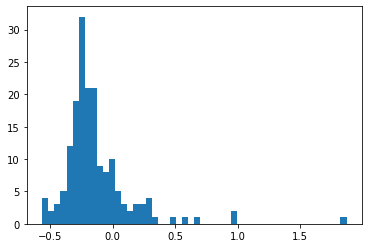

In [72]:
plt.hist(data['change'],50)

In [81]:
bins = [-1, -0.25, -0.1, 2]
labels = ['Low position','Middle',"High position"]
data['Quotes_label'] = pd.cut(data['change'], bins=bins, labels=labels)
data.head()

,BBANDS_upperband,BBANDS_middleband,BBANDS_lowerband,DEMA,EMA,HT_TRENDLINE,macd,macdsignal,macdhist,mfi,...,obv,atr,natr,trange,EMA-trend,MACD-position,MACD-indicator,volatility,change,Quotes_label
token,,,,,,,,,,,,,,,,,,,,,
BTCUSDT,0.362322,0.361992,0.367133,0.649796,0.476603,0.684001,0.491082,0.494432,0.506317,0.399946,...,0.366103,0.214097,0.178244,0.151610,Up trend,sell,low,0.336364,-0.069570,High position
ETHUSDT,0.489594,0.511084,0.502709,0.653345,0.826105,0.704747,0.142334,0.165321,0.608019,0.331334,...,0.806731,0.326164,0.184263,0.106257,Up trend,sell,low,0.518808,-0.124980,Middle
BNBUSDT,0.229414,0.192204,0.223952,0.431558,0.318604,0.491981,0.365145,0.317297,0.766872,0.348333,...,0.358931,0.171564,0.091356,0.052739,Up trend,sell,low,0.593437,-0.164691,Middle
NEOUSDT,0.094165,0.107352,0.124070,0.387119,0.182593,0.293207,0.298248,0.265877,0.721418,0.253389,...,0.754360,0.097001,0.113505,0.023239,Up trend,sell,low,0.879083,-0.246930,Middle
LTCUSDT,0.107873,0.126731,0.146753,0.465039,0.197860,0.355040,0.344851,0.366748,0.660535,0.160331,...,0.039643,0.140491,0.134167,0.041636,Up trend,sell,low,0.717967,-0.106643,Middle


In [82]:
data['Quotes_label'].value_counts()

Low position     66
Middle           61
High position    46
Name: Quotes_label, dtype: int64

In [83]:
data = data.drop(['volatility','change'],axis=1)
data.to_csv('Crypto_quotes_with_change_label.csv',encoding='utf8')

adding quality columns

1. transfer the macd in the gold cross and dead cross
2. 9/26 EMA crossover